# Importação dos arquivos e das bibliotecas necessárias

---




## Importação de bibliotecas

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ferramentas de Pré-processamento do Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos e Métricas
import xgboost as xgb
from sklearn import metrics

# Configurações de visualização
sns.set_theme(style="whitegrid", palette="viridis")
plt.style.use('seaborn-v0_8-whitegrid')

## Importação de arquivos



In [20]:
try:
  df_train = pd.read_csv('/content/wage_train.csv', index_col=0, skipinitialspace=True)
  df_train.replace('?', np.nan, inplace=True)
  print("Dataset de treino carregado com sucesso.")
except FileNotFoundError:
  print("Arquivo '/wage_train.csv' não encontrado. Verifique o caminho.")
  df_train = None

Dataset de treino carregado com sucesso.


# Estatísticas descritivas



/tmp/ipython-input-21-312131004.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1, 1], x=prop_df_edu['>50K'], y=prop_df_edu.index, palette="viridis", order=education_order)
/tmp/ipython-input-21-312131004.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[2, 0], x=prop_df_occ['>50K'], y=prop_df_occ.index, palette="viridis")


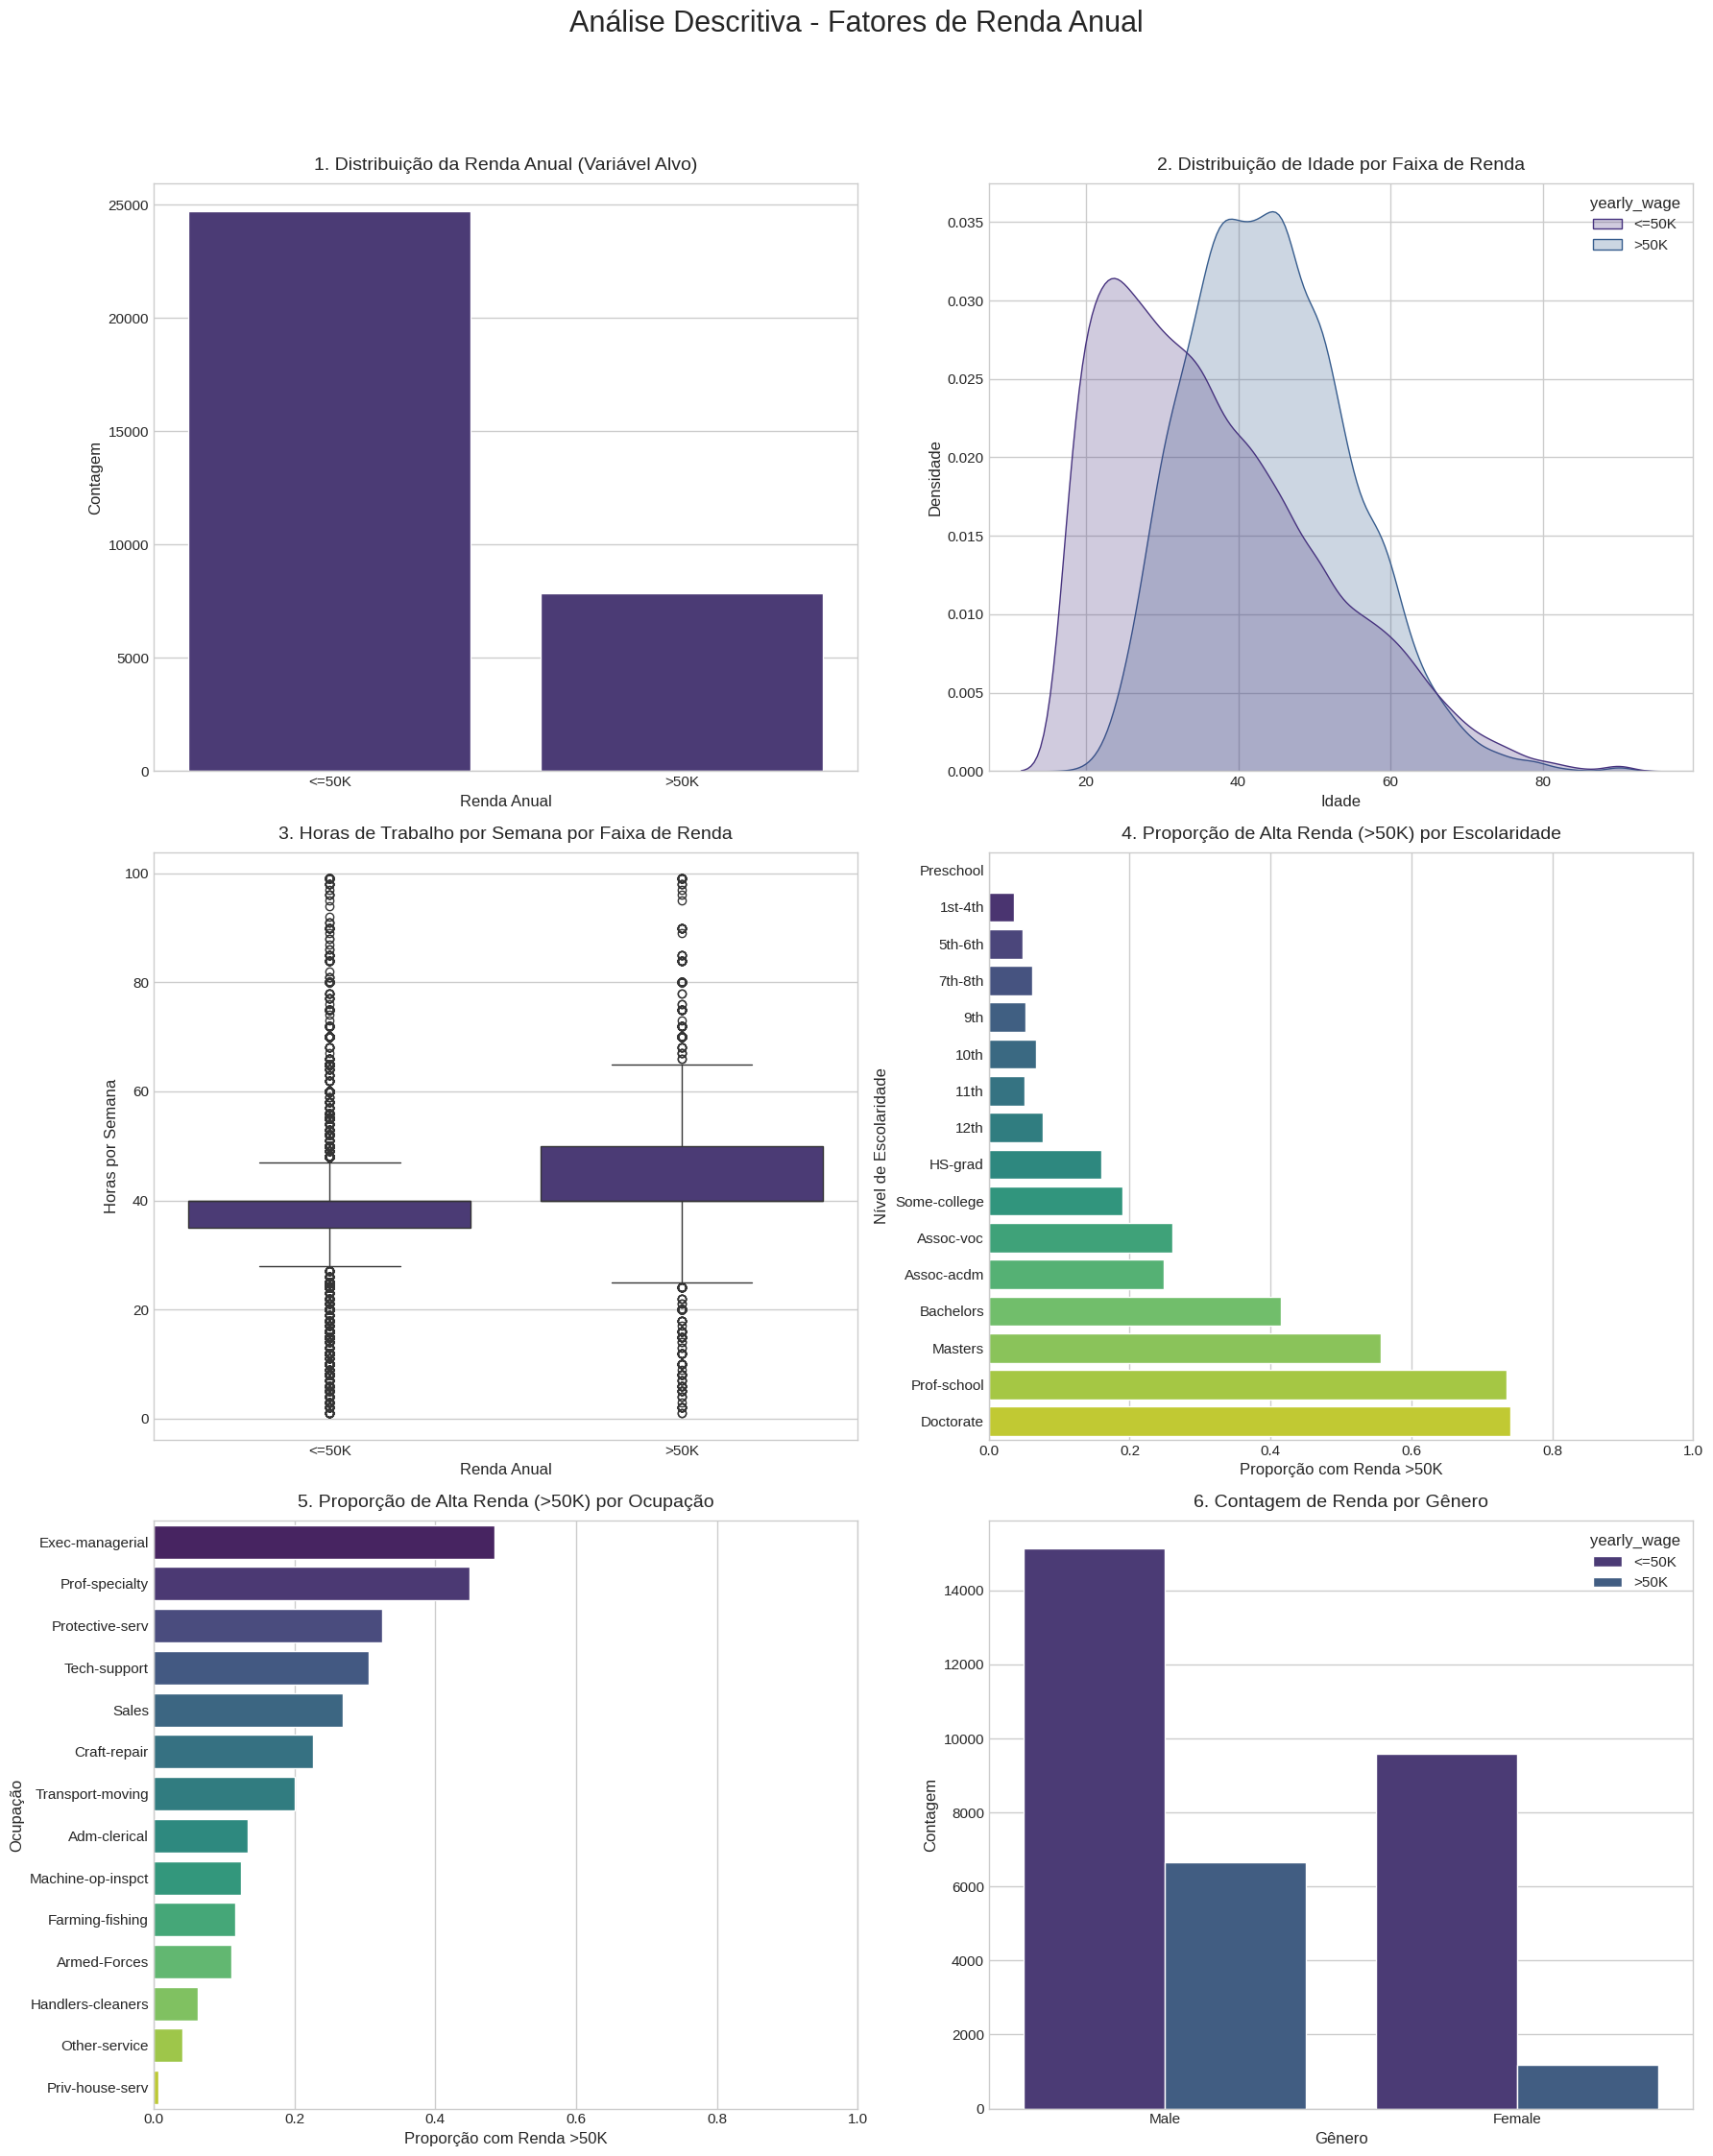

In [21]:
# --- Configuração do Painel de Gráficos ---
fig, axes = plt.subplots(3, 2, figsize=(18, 22))
fig.suptitle('Análise Descritiva - Fatores de Renda Anual', fontsize=22, y=1.02)

# --- Gráfico 1: Distribuição da Variável Alvo (Renda Anual) ---
sns.countplot(ax=axes[0, 0], data=df_train, x='yearly_wage')
axes[0, 0].set_title('1. Distribuição da Renda Anual (Variável Alvo)', fontsize=14, pad=10)
axes[0, 0].set_xlabel('Renda Anual', fontsize=12)
axes[0, 0].set_ylabel('Contagem', fontsize=12)

# --- Gráfico 2: Distribuição de Idade por Faixa de Renda ---
sns.kdeplot(ax=axes[0, 1], data=df_train, x='age', hue='yearly_wage', fill=True, common_norm=False)
axes[0, 1].set_title('2. Distribuição de Idade por Faixa de Renda', fontsize=14, pad=10)
axes[0, 1].set_xlabel('Idade', fontsize=12)
axes[0, 1].set_ylabel('Densidade', fontsize=12)

# --- Gráfico 3: Horas de Trabalho por Semana por Faixa de Renda ---
sns.boxplot(ax=axes[1, 0], data=df_train, x='yearly_wage', y='hours_per_week')
axes[1, 0].set_title('3. Horas de Trabalho por Semana por Faixa de Renda', fontsize=14, pad=10)
axes[1, 0].set_xlabel('Renda Anual', fontsize=12)
axes[1, 0].set_ylabel('Horas por Semana', fontsize=12)

# --- Gráfico 4: Proporção de Alta Renda por Nível de Escolaridade ---
education_order = df_train.groupby('education')['education_num'].mean().sort_values().index
prop_df_edu = df_train.groupby('education')['yearly_wage'].value_counts(normalize=True).unstack().fillna(0)
sns.barplot(ax=axes[1, 1], x=prop_df_edu['>50K'], y=prop_df_edu.index, palette="viridis", order=education_order)
axes[1, 1].set_title('4. Proporção de Alta Renda (>50K) por Escolaridade', fontsize=14, pad=10)
axes[1, 1].set_xlabel('Proporção com Renda >50K', fontsize=12)
axes[1, 1].set_ylabel('Nível de Escolaridade', fontsize=12)
axes[1, 1].set_xlim(0, 1)

# --- Gráfico 5: Proporção de Alta Renda por Ocupação ---
# Preencher NaNs com 0 caso uma categoria não tenha exemplos de >50K
prop_df_occ = df_train.groupby('occupation')['yearly_wage'].value_counts(normalize=True).unstack().fillna(0).sort_values(by='>50K', ascending=False)
sns.barplot(ax=axes[2, 0], x=prop_df_occ['>50K'], y=prop_df_occ.index, palette="viridis")
axes[2, 0].set_title('5. Proporção de Alta Renda (>50K) por Ocupação', fontsize=14, pad=10)
axes[2, 0].set_xlabel('Proporção com Renda >50K', fontsize=12)
axes[2, 0].set_ylabel('Ocupação', fontsize=12)
axes[2, 0].set_xlim(0, 1)

# --- Gráfico 6: Proporção de Alta Renda por Gênero ---
sns.countplot(ax=axes[2, 1], data=df_train, x='sex', hue='yearly_wage')
axes[2, 1].set_title('6. Contagem de Renda por Gênero', fontsize=14, pad=10)
axes[2, 1].set_xlabel('Gênero', fontsize=12)
axes[2, 1].set_ylabel('Contagem', fontsize=12)

# Ajustar layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# Pré-processamento de dados

---



## Engenharia de features


In [22]:
if df_train is not None:
  # Combinar capital_gain e capital_loss em uma única feature mais informativa
  df_train['capital_diff'] = df_train['capital_gain'] - df_train['capital_loss']

  # Remover colunas que não usaremos (redundantes ou com pouco sinal)
  df_train.drop(['capital_gain', 'capital_loss', 'education', 'fnlwgt'], axis=1, inplace=True)
  print("Done")

Done


## Divisão dos dados

In [12]:
# O alvo 'yearly_wage' é codificado para 0 (<=50K) e 1 (>50K)
df_train['yearly_wage'] = df_train['yearly_wage'].apply(lambda x: 1 if x=='>50K' else 0)

# Separar features (X) e alvo (y)
x = df_train.drop('yearly_wage', axis=1)
y = df_train['yearly_wage']

# Dividir em conjuntos de treino e teste (75% treino, 25% teste)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, stratify=y)
print(f"\nDados divididos em treino ({x_train.shape[0]} amostras) e teste ({x_test.shape[0]} amostras).")



Dados divididos em treino (24420 amostras) e teste (8140 amostras).


## Construção do pipeline de transformação de dados


In [13]:
# Identificar colunas numéricas e categóricas automaticamente
numerical_features = x.select_dtypes(include=np.number).columns.tolist()
categorical_features = x.select_dtypes(exclude=np.number).columns.tolist()
print("\nFeatures Numéricas:", numerical_features)
print("Features Categóricas:", categorical_features)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)
print("\nPipeline de pré-processamento criada.")


Features Numéricas: ['age', 'education_num', 'hours_per_week', 'capital_diff']
Features Categóricas: ['workclass', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']

Pipeline de pré-processamento criada.



# Treinamento dos dados

## Construção do pipeline de treinamento


In [14]:
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# Definimos uma range pequena de hiperparâmetros para encontrar os melhores
param_grid = {
    'classifier__n_estimators': [200, 300],
    'classifier__max_depth': [5, 7],
    'classifier__learning_rate': [0.1],
    'classifier__scale_pos_weight': [(len(y_train) - sum(y_train)) / sum(y_train)]
}

grid_search = GridSearchCV(full_pipeline, param_grid, cv=5, n_jobs=-1, scoring='f1_weighted', verbose=1)

print("\nIniciando a otimização do XGBoost")
grid_search.fit(x_train, y_train)

print(f"\nMelhores parâmetros encontrados: {grid_search.best_params_}")

# Pegar o melhor modelo treinado
best_model = grid_search.best_estimator_


Iniciando a otimização do XGBoost
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:42:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Melhores parâmetros encontrados: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 300, 'classifier__scale_pos_weight': 3.1523550416595816}


## Avaliação do modelo



--- Resultados Finais ---
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      6180
           1       0.63      0.87      0.73      1960

    accuracy                           0.85      8140
   macro avg       0.79      0.85      0.81      8140
weighted avg       0.88      0.85      0.85      8140

Matriz de Confusão:
[[5174 1006]
 [ 251 1709]]


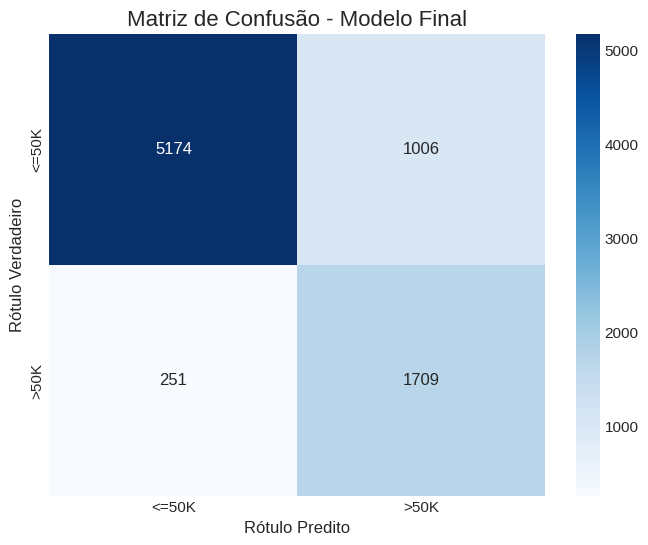

In [15]:
y_pred = best_model.predict(x_test)

print("\n--- Resultados Finais ---")
print(metrics.classification_report(y_test, y_pred))

cm = metrics.confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(cm)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.title('Matriz de Confusão - Modelo Final', fontsize=16)
plt.ylabel('Rótulo Verdadeiro', fontsize=12)
plt.xlabel('Rótulo Predito', fontsize=12)
plt.show()

## Análise da Importância das Features

/tmp/ipython-input-16-3521962833.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')


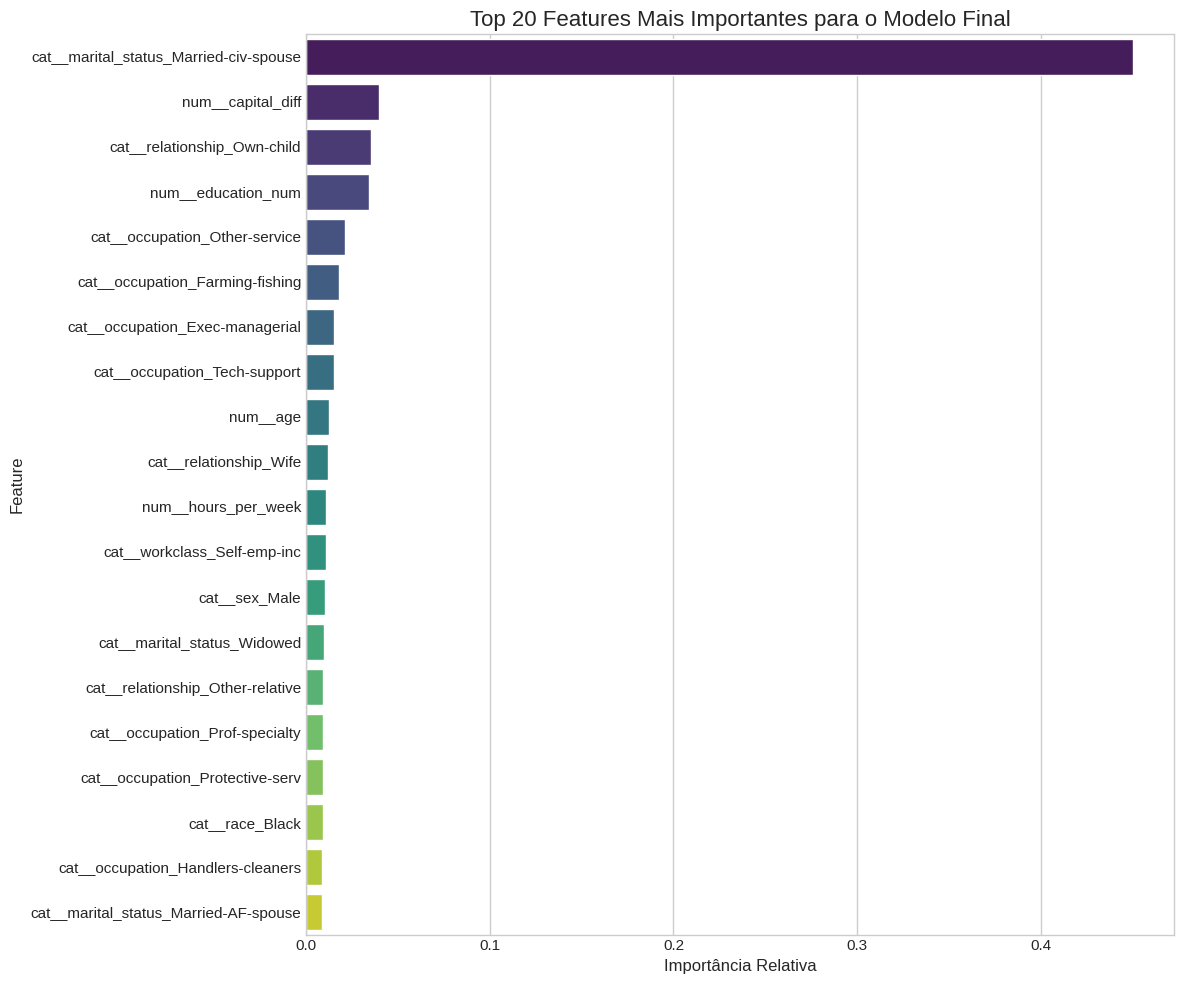

In [16]:
# Extrair os componentes da pipeline
preprocessor_fitted = best_model.named_steps['preprocessor']
xgb_classifier_fitted = best_model.named_steps['classifier']

# Extrair importâncias e nomes das features
importances = xgb_classifier_fitted.feature_importances_
feature_names = preprocessor_fitted.get_feature_names_out()

feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Plotar o gráfico
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')
plt.title('Top 20 Features Mais Importantes para o Modelo Final', fontsize=16)
plt.xlabel('Importância Relativa', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

## Análise dos resultados

O principal destaque do modelo é seu altíssimo Recall de 87%. Indicando que, de todo o universo de indivíduos que de fato ganham mais de 50K, o modelo foi capaz de identificar corretamente 87% deles. A matriz de confusão confirma isso, mostrando que apenas 251 indivíduos de alta renda foram Falsos Negativos, enquanto 1709 foram Verdadeiros Positivos. Este é um modelo de alta cobertura, excelente para cenários onde o objetivo é maximizar a captação de leads.

 O tradeoff foi na precisão. A Precisão de 63% para a classe >50K significa que, quando o modelo prevê que alguém tem alta renda, ele está correto 63% das vezes. O custo disso são os 1006 Falsos Positivos, que representam o esforço que seria direcionado a um público não qualificado.

Em relação as features. A variável mais importante, com uma influência muito superior às demais, é o estado civil, especificamente a categoria cat__marital_status_Married-civ-spouse. O modelo aprendeu que ser casado em união civil é o indicador mais forte da faixa de renda. Outros Fatores relevantes foram: num__capital_diff, relationship_Own-child, education_num e a ocupação.

Por fim, modelo atual apresenta um resultado sólido, mas seu desempenho pode ser elevado através de estratégias de ajuste fino. Uma otimização de hiperparâmetros mais exaustiva e a criação de novas features são os próximos passos. Além disso, ajustar o limiar de decisão é pode melhorar alguns resultados, com base em qual aspecto do problema desejamos abordar.